<a id='back_to_top'></a>

# Table of Content

- ### [Imports](#imports)
- ### [Functions](#functions)
- ### [Setting the parameters](#parameters)
- ### [Loading the features and data types](#loading_features)
- ### [Loading target and initial data analysis](#loading_target)
- ### [Choose features for clustering](#choose_features)
- ### [K - Means and Homogeneity calculations](#kmeans)

[back to top](#back_to_top)  <a id='imports'></a>

# To Do: 

There are two main things to do: 
- add the homogeneity estimation part
- at the moment zero values are manually set to 0.01, and so after log it is 0.01, creating somewhat artifical clusters in the data. So, examine the Box-Cox directly, or as part of the sklearn package, as in: "from sklearn.preprocessing import PowerTransformer"  (see [here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html))

## Imports

In [1]:
import matplotlib
matplotlib.use('nbagg')

import os
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.stats as stats
import random
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
import pandas as pd
import time
import seaborn as sb

In [2]:
# Set Pandas to display more columns as default
pd.options.display.max_columns=30

The following line is for preventing warnings raised for operations done on copied slices of data frames. See here mid-page for more info.
In short, as the default state for the copy action is 'deep = True', the data-frame that is created is indeed a copy and not a view, and so actions on it won't change the original frame it is copied from.

In [3]:
pd.options.mode.chained_assignment = None

[back to top](#back_to_top)  <a id='functions'></a>

## Functions

#### Loading data

In [4]:
def read_data_from_pickle(file_name, sort = True, by_column = 'dim_user_gid'): 
    
    data = pd.read_pickle(file_name)
    data["dim_user_gid"].astype(int)

    print("\nA short summary of the uploaded file:")
    print("The data was loaded into a data-frame.")
    print("There are {} different rows, and {} different columns.".format(data.shape[0], data.shape[1]))
    print("There are {} unique values at the dim_user_gid column.".format(data['dim_user_gid'].nunique()))
    print("There are {} *nan* values at the dim_user_gid column.".format(data['dim_user_gid'].isnull().sum()))

    if sort:
        data = data.sort_values(by = [by_column])
        print("The data-frame was sorted by the {} column.\n".format(by_column))
    
    return data

In [5]:
def read_data_from_json(file_name): 
    
    with open(file_name) as json_file_name:
        data = json.load(json_file_name)
    
    return data

#### Plotting

In [6]:
def hist_of_numerical_feature(data_frame, column, n_bins, figure_size = (10, 6)):

    x = data_frame[column].to_numpy()
    plt.figure(figsize=figure_size)
    n, bins, patches = plt.hist(x, bins=n_bins, edgecolor='black')
    ticks = 0.5 * np.diff(bins) + bins[:-1]
    plt.xticks(ticks, np.ceil(ticks))
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_xticks()
    # using format string '{:.0f}' here but you can choose others
    plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])
    plt.xticks(rotation=90)

    # Set x-axis label
    plt.xlabel(column, labelpad=20, size=16)
    plt.ylabel("Count", labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)

    plt.show()

In [7]:
def plot_loglog_scale(data_frame, column, n_bins, figure_size = (10, 6)):

    x = data_frame[column].to_numpy()
    counts, bins, patches = get_hist_info(x, n_bins)
    bins_center = 0.5 * np.diff(bins) + bins[:-1]
    
    plt.figure(figsize=figure_size)
        
    plt.loglog(bins_center, counts, '.-')

    plt.xlabel('$log_{10}$' + '({}) '.format(column), labelpad=20, size=16)
    plt.ylabel('$log_{10}$ (counts) ', labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)
    
    plt.show()

In [8]:
def get_hist_info(x, n_bins): 
    
    n, bins, patches = plt.hist(x, bins=n_bins)
    plt.close()

    return n ,bins, patches

In [9]:
def plot_data_by_index(data_frame, column, marker_size = 0.5, figure_size = (10, 6)): 
    
    plt.figure(figsize=figure_size)
    plt.plot(range(data_frame[column].shape[0]), data_frame[column], '.', markersize = marker_size)
    plt.xlabel('Index in Data', labelpad=20, size=16)
    plt.ylabel(column, labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)

    plt.show()

#### Data-frames related

In [90]:
def find_users_in_both_features_data_and_target(data_frame, 
                                                target_frame,
                                                print_to_screen,
                                                sort = True, 
                                                by_column = 'dim_user_gid'):
    
    result = pd.merge(data_frame, target_frame, on = by_column)

    if print_to_screen:
        print("\nA short summary:")
        print("The target frame was merged with the historical data frame, and it includes *only* users that appears in both.")
        print("There are {} different rows, and {} different columns.".format(result.shape[0], result.shape[1]))
        print("There are {} *nan* values at the dim_user_gid column.".format((result.shape[0] - result['dim_user_gid'].count())))
        print("There are {} unique values at the dim_user_gid column.".format(result['dim_user_gid'].nunique()))
    
    result = result.drop_duplicates(subset=["dim_user_gid"], keep='last')
    if sort:
        result = result.sort_values(by = [by_column])
    
    if print_to_screen:
        print("\nKeeping only the last entry of each duplicate.\nThe end data frame has {} rows.".format(result.shape[0]))
        print("It was sorted by the {} column.\n".format(by_column))
    
    return result

#### data_analysis

In [95]:
def run_revenue_init_data_analysis(data_target_revenue,
                                   target_column,
                                   plot_figures, 
                                   print_to_screen):
    
    # Calculating the total revenue of a given user (as a user might have had several purchase events in a day)
    data_target_revenue[target_column] = data_target_revenue.groupby(['dim_user_gid'])['revenue_converted_net'].transform('sum').astype(float)

    # Adding a column with the number of purchase events of a user
    data_target_revenue['num_purchase_events_of_user'] = data_target_revenue.groupby('dim_user_gid')['dim_user_gid'].transform('size')

    # Keeping just the information per a user id
    data_target_revenue = data_target_revenue.drop_duplicates(subset=['dim_user_gid']).drop('revenue_converted_net', axis = 1)
    
    if plot_figures: 
        print("\n\nLooking at the distribution of the revenue at the given day:")
        n_bins = 200
        plot_loglog_scale(data_target_revenue, target_column, n_bins)
        
        print("\n\nLooking at the revenue as a function of the user's index in the data frame:")
        print("(which is a proxy to the user's ID, which is a proxy to the user's seniority)")
        marker_size = 2
        plot_data_by_index(data_target_revenue, target_column, marker_size)
        

    if print_to_screen:
        print("\nThe shape of the target data frame is:\n{}".format(data_target_revenue.shape))
        print("\nThere are {} **zeros** and {} **nan** in the {} column".format(len(data_target_revenue[data_target_revenue[target_column] == 0]), \
                                                                                data_target_revenue[target_column].isnull().sum(), \
                                                                                target_column))
        print("\nAnd the types of the data is:")
        print(data_target_revenue.dtypes)
    
    
    return data_target_revenue

#### K-Means related functions

In [12]:
def randomly_choose_features_for_clustering(numerical_features,
                                            num_of_tupples,
                                            num_of_features):
    
    features_for_clustering = []
    for k in range(num_of_tupples):
        features_tupple = randomly_choose_features(numerical_features, num_of_features)
        features_for_clustering.append(features_tupple)
        
    return features_for_clustering

In [13]:
def randomly_choose_features(numerical_columns, num_of_features):
    
    if num_of_features == len(numerical_columns):
        return numerical_columns
    
    elif num_of_features > len(numerical_columns):
        print("\n\nWarning!! The number of features to be randomly chosen should not be larger than")
        print("the number of features available!!")
        print("Returning an empty list.\n\n")
        return []
    
    else: 
        features_for_clustering = random.sample(numerical_columns, k = num_of_features)
        
    
    return features_for_clustering

In [14]:
def checking_validity_of_hand_picked_features(features_for_clustering, numerical_features):
    
    warning_count = 0
    for ind, set_of_features in enumerate(features_for_clustering):
        for feature in set_of_features:
            if feature not in numerical_features:
                print("\n\nWarning!!! The following feature  ** {} **  that was chosen for clustering".format(feature))
                print("in the {} set of features  ** is not numerical!! ** \n\n".format(ind))
                warning_count += 1
                
    if warning_count == 0: 
        print("\n\nAll features' sets hand picked for the clustering include only numerical features.")
        print("Can move on.\n\n")
                

In [15]:
def create_df_for_kmeans(data, 
                         features,
                         parameters_kmeans,
                         print_to_screen):
    
    # Choosing a subset of users: 
    if parameters_kmeans["method"] == "by_recency":
        sliced_data_for_clustering = data.drop(data[data.llrecency >= parameters_kmeans["recency_limit"]].index)
        
    elif parameters_kmeans["method"] == "sliced": 
        sliced_data_for_clustering = data.iloc[(parameters_kmeans["num_of_points"]*parameters_kmeans["segment"]): \
                                               (parameters_kmeans["num_of_points"]*(parameters_kmeans["segment"]+1)), :]
        
    elif parameters_kmeans["method"] == "randomly_choose":  
        # by random sampling 
        if parameters_kmeans["by_fraction"]:
            sliced_data_for_clustering = data.sample(frac = parameters_kmeans["fraction"]) # randomly chooses frac = fraction of the data. 
        else:
            sliced_data_for_clustering = data.sample(n = parameters_kmeans["num_of_points"]) # randomly chooses num_of_points users. 
    
    sliced_data_for_clustering = sliced_data_for_clustering[features] 
    
    if parameters_kmeans["to_log"]: 
        for column in sliced_data_for_clustering.columns.values:
            if column in parameters_kmeans["log_features"]:
                # avoiding errors due to log of negative or zeros. 
                sliced_data_for_clustering.loc[sliced_data_for_clustering[column] <= 0, column] = 0.01 
                sliced_data_for_clustering[column] = np.log10(sliced_data_for_clustering[column]) 
        
    # There shouldn't be nan values in the data after the log transform, as the negative and zero
    # valued elements are set to a positive value. But checking just in case. 
    # If nan do exist, there is the need to figure out the source, and then find 
    # the appropriate solution. 
    check_for_nans(sliced_data_for_clustering, 
                   parameters_kmeans["to_log"], 
                   print_to_screen)

    
    if print_to_screen: 
        print("The chosen features are: {}".format(features))
        print("The data frame for the clustering has the following shape: {}".format(sliced_data_for_clustering.shape))
        print("A quick view of it:\n")
        print(sliced_data_for_clustering.head(10))
        
        
    return sliced_data_for_clustering

In [16]:
def check_for_nans(data, after_log_transform, print_to_screen):
    
    counter = 0
    for column in data.columns: 
        if data[column].isnull().values.any():
            print("\n\nWarning!! There are suspected **nan** values in column: {}".format(column))
            if after_log_transform:
                print("after the log transform.")
            print("Please take care of that! \n\n")
            counter += 1
    
    if print_to_screen:
        if counter == 0: 
            if after_log_transform:
                print("No **nan** values in the data frame for clustering after the log transform. Please continue.")
            else: 
                print("No **nan** values in the data frame for clustering. Please continue.")  

In [17]:
def find_optimal_k(data, param_kmeans, print_to_screen):
    
    optimal_k = {}
    
    print()
    if param_kmeans["optimal_k"]["sse"]["calc_sse"]:
        if print_to_screen:
            print("Started SSE analysis.")
        max_num_k = param_kmeans["optimal_k"]["sse"]["sse_max_num_of_clusters"]
        show_sse_results = param_kmeans["optimal_k"]["sse"]["show_sse_results"]
        optimal_k_sse = find_optimal_k_by_sse(data.drop(columns = ['dim_user_gid']), 
                                              param_kmeans["kmeans_kwargs"],
                                              max_num_k,
                                              show_sse_results,
                                              print_to_screen)
        optimal_k.update({"sse": optimal_k_sse})
        
    print()
    if param_kmeans["optimal_k"]["silhouette"]["calc_silhouette"]:
        if print_to_screen:
            print("Started Silhouette analysis.")
            
        max_num_k = param_kmeans["optimal_k"]["silhouette"]["silhouette_max_num_of_clusters"]
        show_silhouette_results = param_kmeans["optimal_k"]["silhouette"]["show_silhouette_results"]
        optimal_k_silhouette = find_optimal_k_by_silhouette(X.drop(columns = ['dim_user_gid']), 
                                                            param_kmeans["kmeans_kwargs"],
                                                            max_num_k,
                                                            show_silhouette_results,
                                                            print_to_screen)
        optimal_k.update({"silhouette": optimal_k_silhouette})
        
        
    return optimal_k

In [18]:
def find_optimal_k_by_sse(data, 
                          kmeans_kwargs,
                          max_num_k,
                          show_sse_results,
                          print_to_screen):
    
    sse = []
    min_num_k = 1
    
    for k in range(min_num_k, max_num_k + 1):
        if print_to_screen:
            print("Estimating the sse for {} clusters".format(k))        
        
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)

    if show_sse_results:
        plt.style.use("fivethirtyeight")
        plt.plot(range(min_num_k, max_num_k + 1), sse)
        plt.xticks(range(min_num_k, max_num_k + 1))
        plt.xlabel("Number of Clusters")
        plt.ylabel("SSE")
        plt.show()
    
    kl = KneeLocator(range(min_num_k, max_num_k + 1), sse, curve="convex", direction="decreasing")
    sse_optimal_k = kl.elbow
    if print_to_screen:
        print("\nThe preferred number of clusters by sse is: {}.".format(sse_optimal_k)) 

    
    return sse_optimal_k

In [19]:
def find_optimal_k_by_silhouette(data, 
                                 kmeans_kwargs,
                                 max_num_k,
                                 show_silhouette_results,
                                 print_to_screen):
    
    silhouette_coefficients = []
    min_num_k = 2

    for k in range(min_num_k, max_num_k + 1):
        if print_to_screen:
            print("Estimating the Silhouette for {} clusters".format(k))
        
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(data)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_coefficients.append(score)
    
    if show_silhouette_results:
        plt.style.use("fivethirtyeight")
        plt.plot(range(min_num_k, max_num_k + 1), silhouette_coefficients)
        plt.xticks(range(min_num_k, max_num_k + 1))
        plt.xlabel("Number of Clusters")
        plt.ylabel("Silhouette Coefficient")
        plt.show()
        
    silhouette_max = max(silhouette_coefficients)
    silhouette_optimal_k = silhouette_coefficients.index(silhouette_max) + 2
    if print_to_screen:
        print("\nThe preferred number of clusters by silhouette is: {}.".format(silhouette_optimal_k)) 
    
    return silhouette_optimal_k

In [20]:
def run_kmeans(X, 
               num_of_clusters, 
               param_kmeans,
               print_to_screen):
    
    start_time = time.time()
    
    kmeans = KMeans(n_clusters=num_of_clusters, **param_kmeans["kmeans_kwargs"])
    X["Cluster"] = kmeans.fit_predict(X.drop(columns = ['dim_user_gid']))
    X["Cluster"] = X["Cluster"].astype("category")
    
    end_time = time.time()
    if print_to_screen:
        print("The Kmeans calculation for {} dimensions and {} rows was:\n{}sec".format(X.shape[1] - 2, X.shape[0], end_time - start_time))

    if param_kmeans["show_clustering_plots"]:
        if X.shape[1] - 2 > 3:  # reducing the number of columns by 2, as one column is dim_user_gid, and the other is the cluster results
            print("\n\n\nCan't visually show the clustering results, as the number of features is larger than three!!!\n\n")
        elif X.shape[1] - 2 == 3:
            plot_clusters_three_features(X)
        elif X.shape[1] - 2 == 2:
            plot_clusters_two_features(X)

    return X
    

In [21]:
def plot_clusters_three_features(X):

    sb.set(style = "darkgrid")

    fig = plt.figure(figsize = (12, 10))
    ax = Axes3D(fig)
    ax = fig.add_subplot(111, projection = '3d')

    x = X.iloc[:, [1]]
    y = X.iloc[:, [2]]
    z = X.iloc[:, [3]]

    ax.set_xlabel(X.columns[1])
    ax.set_ylabel(X.columns[2])
    ax.set_zlabel(X.columns[3])

    sc = ax.scatter(x, y, z, c = X['Cluster'])
    ax.legend(*sc.legend_elements(), title='clusters')

    plt.show()

In [22]:
def plot_clusters_two_features(X):
    
    sb.relplot(
        x=X.columns[1], y=X.columns[2], hue="Cluster", data=X, height=6)

    plt.show()

#### Homogeneity related functions

In [72]:
def plot_dist_of_target_at_clusters(X_merged_with_target,
                                    x_label):

    # Plotting the spread of the target values in each of the clusters:
    sb.catplot(x= x_label, y="Cluster", data=X_merged_with_target, kind="boxen", height=6)
    plt.show()

In [142]:
def calc_homogeneity(X_merged_with_target,
                     num_of_clusters,
                     target_column,
                     param_homogeneity,
                     print_to_screen):
    
    target_at_clusters_sizes = get_cluster_sizes(X_merged_with_target, num_of_clusters)
    
    homogeneity_results = {}
    if param_homogeneity["percentile"]["to_run"]:
        
        target_percentile_diff = np.percentile(X_merged_with_target[target_column], param_homogeneity["percentile"]["upper_percentile"]) - \
                                    np.percentile(X_merged_with_target[target_column], param_homogeneity["percentile"]["lower_percentile"])
        
        homogeneity_by_percentile = get_percentile_homogeneity(X_merged_with_target,
                                                               num_of_clusters,
                                                               target_at_clusters_sizes,
                                                               target_column,
                                                               target_percentile_diff,
                                                               param_homogeneity["percentile"]["lower_percentile"],
                                                               param_homogeneity["percentile"]["upper_percentile"])
        
        homogeneity_results.update({"homogeneity_by_percentile": homogeneity_by_percentile})
        
    if param_homogeneity["min_max"]["to_run"]:
        
        target_min_max_diff = np.max(X_merged_with_target[target_column]) - np.min(X_merged_with_target[target_column])

        homogeneity_by_min_max = get_min_max_homogeneity(X_merged_with_target,
                                                         num_of_clusters,
                                                         target_at_clusters_sizes,
                                                         target_column,
                                                         target_min_max_diff)
        
        homogeneity_results.update({"homogeneity_by_min_max": homogeneity_by_min_max})

    if param_homogeneity["distance"]["to_run"]:
        
        mean_distances_target = calculate_squared_distances(X_merged_with_target[target_column])
        
        homogeneity_by_distance = get_distance_homogeneity(X_merged_with_target,
                                                           num_of_clusters,
                                                           target_at_clusters_sizes,
                                                           target_column,
                                                           mean_distances_target)
        
        homogeneity_results.update({"homogeneity_by_distance": homogeneity_by_distance})
        
    if param_homogeneity["bootstrap"]:
        bootstrap_results = homogeneity_bootstrap(X_merged_with_target,
                                                  target_column,
                                                  target_at_clusters_sizes,
                                                  param_homogeneity,
                                                  print_to_screen)
        
        homogeneity_results.update({"bootstrap_results": bootstrap_results})
        
    
    return homogeneity_results

In [102]:
def get_cluster_sizes(data, num_of_clusters):
    
    cluster_sizes = [len(data[data['Cluster'] == cluster]['Cluster']) for cluster in range(num_of_clusters)]
    
    return cluster_sizes

In [117]:
def get_percentile_homogeneity(X_merged_with_target,
                               num_of_clusters,
                               target_at_clusters_sizes,
                               target_column,
                               target_percentile_diff,
                               low_percentile,
                               up_percentile):
    
    percentile_homogeneity = {}
    
    homogeneity = []
    weighted_homogeneity = []
    for cluster in range(num_of_clusters):
        cluster_percentile_diff = np.percentile(X_merged_with_target[X_merged_with_target['Cluster'] == cluster][target_column], up_percentile) - \
                                    np.percentile(X_merged_with_target[X_merged_with_target['Cluster'] == cluster][target_column], low_percentile)
        homogeneity.append((1 - cluster_percentile_diff/target_percentile_diff))
        weighted_homogeneity.append(homogeneity[-1]*target_at_clusters_sizes[cluster])
    
    percentile_homogeneity.update({"homogeneity": homogeneity})
    percentile_homogeneity.update({"homogeneity_avg": np.mean(homogeneity)})
    
    percentile_homogeneity.update({"weighted_homogeneity": weighted_homogeneity})
    percentile_homogeneity.update({"weighted_homogeneity_avg": sum(weighted_homogeneity)/X_merged_with_target.shape[0]})
        
    return percentile_homogeneity

In [125]:
def get_min_max_homogeneity(X_merged_with_target,
                            num_of_clusters,
                            target_at_clusters_sizes,
                            target_column,
                            target_min_max_diff):
    
    min_max_homogeneity = {}
    
    homogeneity = []
    weighted_homogeneity = []
    for cluster in range(num_of_clusters):
        cluster_min_max_diff = np.max(X_merged_with_target[X_merged_with_target['Cluster'] == cluster][target_column]) - \
                                np.min(X_merged_with_target[X_merged_with_target['Cluster'] == cluster][target_column])
        homogeneity.append((1 - cluster_min_max_diff/target_min_max_diff))
        weighted_homogeneity.append(homogeneity[-1]*target_at_clusters_sizes[cluster])
    
    min_max_homogeneity.update({"homogeneity": homogeneity})
    min_max_homogeneity.update({"homogeneity_avg": np.mean(homogeneity)})
    
    min_max_homogeneity.update({"weighted_homogeneity": weighted_homogeneity})
    min_max_homogeneity.update({"weighted_homogeneity_avg": sum(weighted_homogeneity)/X_merged_with_target.shape[0]})
    
    
    return min_max_homogeneity

In [124]:
def get_distance_homogeneity(X_merged_with_target,
                             num_of_clusters,
                             target_at_clusters_sizes,
                             target_column,
                             mean_distances_target):
    
    distance_homogeneity = {}
    
    homogeneity = []
    weighted_homogeneity = []
    for cluster in range(num_of_clusters):
        mean_distances_cluster = calculate_squared_distances(X_merged_with_target[X_merged_with_target['Cluster'] == cluster][target_column])

        homogeneity.append((1 - mean_distances_cluster/mean_distances_target))
        weighted_homogeneity.append(homogeneity[-1]*target_at_clusters_sizes[cluster])
    
    distance_homogeneity.update({"homogeneity": homogeneity})
    distance_homogeneity.update({"homogeneity_avg": np.mean(homogeneity)})
    
    distance_homogeneity.update({"weighted_homogeneity": weighted_homogeneity})
    distance_homogeneity.update({"weighted_homogeneity_avg": sum(weighted_homogeneity)/X_merged_with_target.shape[0]})
    
    
    return distance_homogeneity

In [123]:
def calculate_squared_distances(data):
    
    mean_value = np.mean(data)
    distances = []
    for elem in data:
        distances.append((elem - mean_value)**2)
        
    mean_distances = sum(distances)/len(data)
    
    return mean_distances

#### Bootstrapping

In [154]:
def homogeneity_bootstrap(X_merged_with_target,
                          target_column,
                          target_at_clusters_sizes,
                          param_homogeneity,
                          print_to_screen):
    
    
    bootstrap_results = {}

    avg_homogeneity_percentile = []
    avg_weighted_homogeneity_percentile = []
    avg_homogeneity_min_max = []
    avg_weighted_homogeneity_min_max = []
    avg_homogeneity_distances = []
    avg_weighted_homogeneity_distances = []
    
    for k in range(param_homogeneity["num_of_bootstrap_runs"]):
        if print_to_screen:
            if k%2000 == 0:
                print(k)
                
        splits = calc_target_splits(X_merged_with_target, 
                                    target_column, 
                                    target_at_clusters_sizes)
        
        splits_merged = [item for sublist in splits for item in sublist]
        
        if param_homogeneity["percentile"]["to_run"]:
            avg_homogeneity, avg_weighted_homogeneity = calc_homogeneity_by_percentile_for_splits(splits, 
                                                                                                  splits_merged,
                                                                                                  param_homogeneity["percentile"]["lower_percentile"], 
                                                                                                  param_homogeneity["percentile"]["upper_percentile"])
            avg_homogeneity_percentile.append(avg_homogeneity)
            avg_weighted_homogeneity_percentile.append(avg_weighted_homogeneity)
    
        if param_homogeneity["min_max"]["to_run"]:
            avg_homogeneity, avg_weighted_homogeneity = calc_homogeneity_by_MinMax_for_splits(splits,
                                                                                              splits_merged)
            avg_homogeneity_min_max.append(avg_homogeneity)
            avg_weighted_homogeneity_min_max.append(avg_weighted_homogeneity)
        
        if param_homogeneity["distance"]["to_run"]:
            avg_homogeneity, avg_weighted_homogeneity = calc_homogeneity_by_distances_for_splits(splits,
                                                                                                 splits_merged)
            avg_homogeneity_distances.append(avg_homogeneity)
            avg_weighted_homogeneity_distances.append(avg_weighted_homogeneity)
     
    
    print("\n\nPercentile:")
    print("The average homogeneity over the bootstrap samples: {:.5f}".format(np.mean(avg_homogeneity_percentile)))
    print("The 0.025 Percentile is at: {:.5f}".format(np.percentile(avg_homogeneity_percentile, 2.5)))
    print("The 0.975 Percentile is at: {:.5f}".format(np.percentile(avg_homogeneity_percentile, 97.5)))
    print()
    print("The average weighted homogeneity over the bootstrap samples: {:.5f}".format(np.mean(avg_weighted_homogeneity_percentile)))
    print("The 0.025 Percentile is at: {:.5f}".format(np.percentile(avg_weighted_homogeneity_percentile, 2.5)))
    print("The 0.975 Percentile is at: {:.5f}".format(np.percentile(avg_weighted_homogeneity_percentile, 97.5)))
    
    print("\n\MinMax:")
    print("The average homogeneity over the bootstrap samples: {:.5f}".format(np.mean(avg_homogeneity_min_max)))
    print("The 0.025 MinMax is at: {:.5f}".format(np.percentile(avg_homogeneity_min_max, 2.5)))
    print("The 0.975 MinMax is at: {:.5f}".format(np.percentile(avg_homogeneity_min_max, 97.5)))
    print()
    print("The average weighted homogeneity over the bootstrap samples: {:.5f}".format(np.mean(avg_weighted_homogeneity_min_max)))
    print("The 0.025 MinMax is at: {:.5f}".format(np.percentile(avg_weighted_homogeneity_min_max, 2.5)))
    print("The 0.975 MinMax is at: {:.5f}".format(np.percentile(avg_weighted_homogeneity_min_max, 97.5)))
    
    print("\n\Distances:")
    print("The average homogeneity over the bootstrap samples: {:.5f}".format(np.mean(avg_homogeneity_distances)))
    print("The 0.025 Distances is at: {:.5f}".format(np.percentile(avg_homogeneity_distances, 2.5)))
    print("The 0.975 Distances is at: {:.5f}".format(np.percentile(avg_homogeneity_distances, 97.5)))
    print()
    print("The average weighted homogeneity over the bootstrap samples: {:.5f}".format(np.mean(avg_weighted_homogeneity_distances)))
    print("The 0.025 Distances is at: {:.5f}".format(np.percentile(avg_weighted_homogeneity_distances, 2.5)))
    print("The 0.975 Distances is at: {:.5f}".format(np.percentile(avg_weighted_homogeneity_distances, 97.5)))
    
    
    bootstrap_results.update({"percentile": {}})
    bootstrap_results["percentile"].update({"avg_homogeneity": avg_homogeneity_percentile})
    bootstrap_results["percentile"].update({"avg_weighted_homogeneity": avg_weighted_homogeneity_percentile})
    
    bootstrap_results.update({"min_max": {}})
    bootstrap_results["min_max"].update({"avg_homogeneity": avg_homogeneity_min_max})
    bootstrap_results["min_max"].update({"avg_weighted_homogeneity": avg_weighted_homogeneity_min_max})
    
    bootstrap_results.update({"distance": {}})
    bootstrap_results["distance"].update({"avg_homogeneity": avg_homogeneity_distances})
    bootstrap_results["distance"].update({"avg_weighted_homogeneity": avg_weighted_homogeneity_distances})
    

    return bootstrap_results

In [149]:
def calc_target_splits(data, 
                       target_column, 
                       target_at_clusters_sizes): 
        
    shuffled_target = np.random.permutation(data[target_column])
    splits_at = np.cumsum(target_at_clusters_sizes)
    splits = np.split(shuffled_target, splits_at)
    splits.pop(-1)
    
    return splits

In [137]:
def calc_homogeneity_by_percentile_for_splits(splits, 
                                              splits_merged,
                                              low_percentile, 
                                              top_percentile):
    
    overall_percentile_diff = np.percentile(splits_merged, top_percentile) - np.percentile(splits_merged, low_percentile)

    homogeneity = []
    weighted_homogeneity = []
    
    for split in splits:
        split_percentile_diff = np.percentile(split, top_percentile) - np.percentile(split, low_percentile)
        homogeneity.append((1 - split_percentile_diff/overall_percentile_diff))
        weighted_homogeneity.append(homogeneity[-1]*len(split))
    
    return np.mean(homogeneity), sum(weighted_homogeneity)/len(splits_merged)

In [138]:
def calc_homogeneity_by_MinMax_for_splits(splits,
                                          splits_merged):
    
    overall_min_max_diff = np.max(splits_merged) - np.min(splits_merged)

    homogeneity = []
    weighted_homogeneity = []

    for split in splits:
        split_min_max_diff = np.max(split) - np.min(split)
        homogeneity.append((1 - split_min_max_diff/overall_min_max_diff))
        weighted_homogeneity.append(homogeneity[-1]*len(split))

    return np.mean(homogeneity), sum(weighted_homogeneity)/len(splits_merged)

In [140]:
def calc_homogeneity_by_distances_for_splits(splits,
                                             splits_merged):
    
    mean_distances_overall = calculate_squared_distances(splits_merged)

    homogeneity = []
    weighted_homogeneity = []
    
    for split in splits:
        mean_distances_split = calculate_squared_distances(split)
        homogeneity.append((1 - mean_distances_split/mean_distances_overall)) 
        weighted_homogeneity.append(homogeneity[-1]*len(split))
        
    return np.mean(homogeneity), sum(weighted_homogeneity)/len(splits_merged)

[back to top](#back_to_top)  <a id='parameters'></a>

## Setting the parameters

In [24]:
# The main data structure that holds all the required parameters
parameters = {}
results_summary = {}

In [25]:
results_summary.update({"results": {}})

#### Pointers to data to load

In [26]:
parameters.update({"data": {}})

In [27]:
data_dir = "Data"
parameters["data"].update({"data_dir": data_dir})

In [28]:
parameters["data"].update({"data_for_clustering": {}})

Features:

In [29]:
# Data with 5 million users that was cleaned in Part 1, and if the name suggests, may inlcude seniority 
# column as well
data_for_clustering_file_name = "data_features_5_million_users_20220915_cleaned_with_Seniority.pkl"
parameters["data"]["data_for_clustering"].update({"data_file_name": data_for_clustering_file_name})

Features' data types:

In [30]:
# This file is very important and it is needed to be pre-prepared for a given data set for the clustering 
# and target. 
features_data_types_file_name = "dict_of_features_data_type.txt"
parameters["data"]["data_for_clustering"].update({"features_data_types_file_name": features_data_types_file_name})

Target:

In [31]:
parameters["data"].update({"target_data": {}})

In [32]:
# Target data file name
target_data_file_name = "data_target_revenue_20220916.pkl"
parameters["data"]["target_data"].update({"target_data_file_name": target_data_file_name})

In [33]:
target_feature = "revenue"
target_data_type = "numerical"
init_data_analysis = True
plot_figures = True

parameters["data"]["target_data"].update({"target_feature": target_feature})
parameters["data"]["target_data"].update({"target_data_type": target_data_type})
parameters["data"]["target_data"].update({"init_data_analysis": init_data_analysis})
parameters["data"]["target_data"].update({"plot_figures": plot_figures})

In [93]:
change_target_column_name = True
target_column_name = "Total_revenue_at_day"

parameters["data"]["target_data"].update({"change_target_column_name": change_target_column_name})
parameters["data"]["target_data"].update({"target_column_name": target_column_name})

#### Choose features for clustering

In [34]:
parameters.update({"choose_features_for_clustering": {}})

In [105]:
randomly_choose = False
num_of_tupples = 2
num_of_features = 3

parameters["choose_features_for_clustering"].update({"randomly_choose": randomly_choose})
parameters["choose_features_for_clustering"].update({"num_of_tupples": num_of_tupples})
parameters["choose_features_for_clustering"].update({"num_of_features": num_of_features})

In [150]:
# # If randomly_choose = True:
# hand_picked_features_for_clustering = [[]] 

# or, if 'randomly_choose = False', a list of hand-picked features should be given.
# More than one set can be hand-picked, but it needs to be in the format for 
# list of lists. 

# At the moment, the hand-picked features must be from the list of numerical
# features. As an example:

hand_picked_features_for_clustering = [['level', 'Lifetime_Revenue_Net', 'credits_balance_EOD']] 

# # The next two tupples of features leads to a highly homogeneous result (with 6 clusters, 4 show very tight 
# # spread of the revenue target, with the remaining 2 clusters show a very wide spread of target), 
# # and a highly non-homogenoues result (relative equal spread of the revenue target among the clusters). 

# hand_picked_features_for_clustering = [['dim_user_gid', 'Last_90D_Gross_Sink', 'Lifetime_Revenue_Net', 'total_rounds_mode_2'], ['dim_user_gid', 'total_rounds_mode_3', 'coins_balance_EOD', 'credits_balance_EOD']]

parameters["choose_features_for_clustering"].update({"hand_picked_features_for_clustering": hand_picked_features_for_clustering})

#### K-Means

In [37]:
parameters.update({"kmeans": {}})

In [38]:
to_log = True  # whether to log all or some of the features given
log_features = []  # or a list of the features to log transform

parameters["kmeans"].update({"to_log": to_log})
parameters["kmeans"].update({"log_features": log_features})

In [39]:
# For the clustering, the full data-set of millions may take a long time to cluster (at least now 
# at the development phase). 
# So there are several options to slice the full data:

method = "by_recency"  # or "randomly_choose", or "sliced"

# 1. For sliced 
num_of_points = 10000
segment = 2

# 2. Or, for randomly choose: 
by_fraction = True
fraction = 0.2

# 3. Or, by recency:
recency_limit = 3

parameters["kmeans"].update({"method": method})

parameters["kmeans"].update({"recency_limit": recency_limit})

parameters["kmeans"].update({"num_of_points": num_of_points})
parameters["kmeans"].update({"segment": segment})

parameters["kmeans"].update({"by_fraction": by_fraction})
parameters["kmeans"].update({"fraction": fraction})

In [40]:
kmeans_kwargs = {
                "init": "k-means++",
                "n_init": 50,
                "max_iter": 500,
                "random_state": 42,
                }

parameters["kmeans"].update({"kmeans_kwargs": kmeans_kwargs})

In [41]:
parameters["kmeans"].update({"optimal_k": {}})

In [42]:
to_find_optimal_k = False
parameters["kmeans"]["optimal_k"].update({"to_find_optimal_k": to_find_optimal_k})

In [43]:
calc_sse = False
sse_max_num_of_clusters = 10
show_sse_results = False

parameters["kmeans"]["optimal_k"].update({"sse": {}})
parameters["kmeans"]["optimal_k"]["sse"].update({"calc_sse": calc_sse})
parameters["kmeans"]["optimal_k"]["sse"].update({"sse_max_num_of_clusters": sse_max_num_of_clusters})
parameters["kmeans"]["optimal_k"]["sse"].update({"show_sse_results": show_sse_results})

In [44]:
# A flag for whether to calculate the silhouette, as it takes quite some time for large data set.
calc_silhouette = False
silhouette_max_num_of_clusters = 8
show_silhouette_results = False

parameters["kmeans"]["optimal_k"].update({"silhouette": {}})
parameters["kmeans"]["optimal_k"]["silhouette"].update({"calc_silhouette": calc_silhouette})
parameters["kmeans"]["optimal_k"]["silhouette"].update({"silhouette_max_num_of_clusters": silhouette_max_num_of_clusters})
parameters["kmeans"]["optimal_k"]["silhouette"].update({"show_silhouette_results": show_silhouette_results})

In [45]:
choice_of_num_of_clusters = "manual"  # or "sse" or "silhouette"
hand_picked_num_of_clusters = 6

parameters["kmeans"].update({"choice_of_num_of_clusters": choice_of_num_of_clusters})
parameters["kmeans"].update({"hand_picked_num_of_clusters": hand_picked_num_of_clusters})

In [46]:
show_clustering_plots = False
parameters["kmeans"].update({"show_clustering_plots": show_clustering_plots})

#### Homogeneity

In [47]:
parameters.update({"homogeneity": {}})

In [48]:
show_target_distribution_by_cluster = True
parameters["homogeneity"].update({"show_target_distribution_by_cluster": show_target_distribution_by_cluster})

In [66]:
calc_homogeneity = True
parameters["homogeneity"].update({"calc_homogeneity": calc_homogeneity})

In [96]:
percentile = True
lower_percentile = 10
upper_percentile = 90

parameters["homogeneity"].update({"percentile": {}})
parameters["homogeneity"]["percentile"].update({"to_run": percentile})
parameters["homogeneity"]["percentile"].update({"lower_percentile": lower_percentile})
parameters["homogeneity"]["percentile"].update({"upper_percentile": upper_percentile})

In [68]:
min_max = True

parameters["homogeneity"].update({"min_max": {}})
parameters["homogeneity"]["min_max"].update({"to_run": min_max})

In [69]:
distance = True

parameters["homogeneity"].update({"distance": {}})
parameters["homogeneity"]["distance"].update({"to_run": distance})

In [136]:
bootstrap = True
num_of_bootstrap_runs = 10000
parameters["homogeneity"].update({"bootstrap": bootstrap})
parameters["homogeneity"].update({"num_of_bootstrap_runs": num_of_bootstrap_runs})

#### Print information to screen 

In [155]:
print_to_screen = True
parameters.update({"print_to_screen": print_to_screen})

[back to top](#back_to_top)  
[back to setting the parameters](#parameters) <a id='loading_features'></a>

## Loading the features and their data types

In [50]:
features_data_full_file_name = os.path.join(parameters["data"]["data_dir"], \
                                            parameters["data"]["data_for_clustering"]["data_file_name"])

In [51]:
data_for_clustering = read_data_from_pickle(features_data_full_file_name)
data_for_clustering.head(10)


A short summary of the uploaded file:
The data was loaded into a data-frame.
There are 4985297 different rows, and 27 different columns.
There are 4985297 unique values at the dim_user_gid column.
There are 0 *nan* values at the dim_user_gid column.
The data-frame was sorted by the dim_user_gid column.



dim_user_gid  est_seniority top_platform  level  trstier level_bracket  \
23899           261           3628        Apple   74.0      2.0      lv_40_79   
40151           288           3628       Google   77.0      1.0      lv_40_79   
40152           312           3628       Google   97.0      1.0     lv_80_119   
40153           376           3628       Google  126.0      3.0    lv_120_139   
68592           381           3628       Google  129.0      2.0    lv_120_139   
80781           388           3628        Apple   85.0      2.0     lv_80_119   
48277           391           3628          Web  243.0      2.0    lv_200plus   
3584            427           3628     Facebook  208.0      3.0    lv_200plus   
48278           436           3628     Facebook   72.0      2.0      lv_40_79   
68593           454           3628       Google   64.0      2.0      lv_40_79   

       is_elite  is_vip  llrecency  Lifetime_Revenue_Net  \
23899         0       0          4                0.0000   
40151         0       0          1                0.0000   
40152         0       0          1                0.0000   
40153         0       0         10               85.1555   
68592         0       0          1              110.9604   
80781         0       0        121                3.8430   
48277         0       0          1                0.0000   
3584          0       0          1                0.0000   
48278         0       0         41                0.0000   
68593         0       0         49                0.0000   

       Last_30D_Revenue_Net  Last_90D_Revenue_Net  Last_30D_Transactions  \
23899                   0.0                 0.000                      0   
40151                   0.0                 0.000                      0   
40152                   0.0                 0.000                      0   
40153                   0.0                10.493                      0   
68592                   0.0                10.493                      0   
80781                   0.0                 0.000                      0   
48277                   0.0                 0.000                      0   
3584                    0.0                 0.000                      0   
48278                   0.0                 0.000                      0   
68593                   0.0                 0.000                      0   

       Last_30D_Gross_Sink  Last_90D_Gross_Sink  Last_30D_Login_days  \
23899                 42.0                 42.0                    2   
40151                  0.0                  0.0                    6   
40152              16952.0              53355.0                   29   
40153                  0.0               2652.0                    1   
68592                450.0              25135.0                   10   
80781                  0.0                  0.0                    0   
48277              11580.0              34815.0                   30   
3584               21180.0             238137.0                   27   
48278                  0.0                772.0                    0   
68593                  0.0               1944.0                    0   

       Last_90D_Login_days  credits_balance_EOD  coins_balance_EOD  \
23899                    2              23992.0           989739.0   
40151                   17                591.0           129887.0   
40152                   89                279.0           485502.0   
40153                    7               2278.0          2863137.0   
68592                   36               5698.0          1277645.0   
80781                    0               1414.0             4238.0   
48277                   90                  4.0             4128.0   
3584                    87                426.0             9904.0   
48278                    1                204.0           342700.0   
68593                    1                207.0            25913.0   

       number_of_bingo_rounds  Life_Time_Login_Days  

#### As we only use the numerical features with the Kmeans for now, we do the following: 

In [52]:
features_data_type_full_file_name = os.path.join(parameters["data"]["data_dir"], \
                                                 parameters["data"]["data_for_clustering"]["features_data_types_file_name"])

In [53]:
features_data_types = read_data_from_json(features_data_type_full_file_name)

In [54]:
# Loading the dict of the features data types and creating a list that includes only the numerical features. 
numerical_features = [column for column in data_for_clustering.columns if column != 'dim_user_gid' and features_data_types[column] == 'Numerical']

In [55]:
print("There are overall {} numerical features in this data set.".format(len(numerical_features)))
print()
print("They are:")
for feature in numerical_features:
    print("    " + feature)

There are overall 20 numerical features in this data set.

They are:
    level
    llrecency
    Lifetime_Revenue_Net
    Last_30D_Revenue_Net
    Last_90D_Revenue_Net
    Last_30D_Transactions
    Last_30D_Gross_Sink
    Last_90D_Gross_Sink
    Last_30D_Login_days
    Last_90D_Login_days
    credits_balance_EOD
    coins_balance_EOD
    number_of_bingo_rounds
    Life_Time_Login_Days
    total_rounds_mode_1
    total_rounds_mode_2
    total_rounds_mode_3
    total_rounds_mode_4
    total_rounds_mode_5
    total_rounds_mode_6


In [56]:
features_to_log = []

if parameters["kmeans"]["method"] == "by_recency":
    numerical_features.remove("llrecency")
    
for feature in numerical_features:
    features_to_log.append(feature)
        
parameters["kmeans"].update({"log_features": features_to_log})

In [57]:
print(parameters["kmeans"]["log_features"])

['level', 'Lifetime_Revenue_Net', 'Last_30D_Revenue_Net', 'Last_90D_Revenue_Net', 'Last_30D_Transactions', 'Last_30D_Gross_Sink', 'Last_90D_Gross_Sink', 'Last_30D_Login_days', 'Last_90D_Login_days', 'credits_balance_EOD', 'coins_balance_EOD', 'number_of_bingo_rounds', 'Life_Time_Login_Days', 'total_rounds_mode_1', 'total_rounds_mode_2', 'total_rounds_mode_3', 'total_rounds_mode_4', 'total_rounds_mode_5', 'total_rounds_mode_6']


[back to top](#back_to_top)  
[back to setting the parameters](#parameters) <a id='loading_target'></a>

## Loading the target and initial data analysis

In [58]:
target_full_file_name = os.path.join(parameters["data"]["data_dir"], \
                                     parameters["data"]["target_data"]["target_data_file_name"])

In [59]:
data_target = read_data_from_pickle(target_full_file_name)
data_target.head(10)


A short summary of the uploaded file:
The data was loaded into a data-frame.
There are 103211 different rows, and 2 different columns.
There are 51856 unique values at the dim_user_gid column.
There are 0 *nan* values at the dim_user_gid column.
The data-frame was sorted by the dim_user_gid column.



dim_user_gid revenue_converted_net
17184           600                2.9153
81484          1240                3.4930
85786          1307                0.6230
34537          1621               10.4930
72900          1788                6.2930
72899          1788                6.2930
72898          1788                6.2930
72897          1788                0.6930
72896          1788               10.4930
21602          2082               19.5930

In [94]:
if not parameters["data"]["target_data"]["change_target_column_name"]:
    target_column = data_target.columns[1]
else: 
    target_column = parameters["data"]["target_data"]["target_column_name"]



Looking at the distribution of the revenue at the given day:


<ipython-input-8-207e611714e3>:4: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


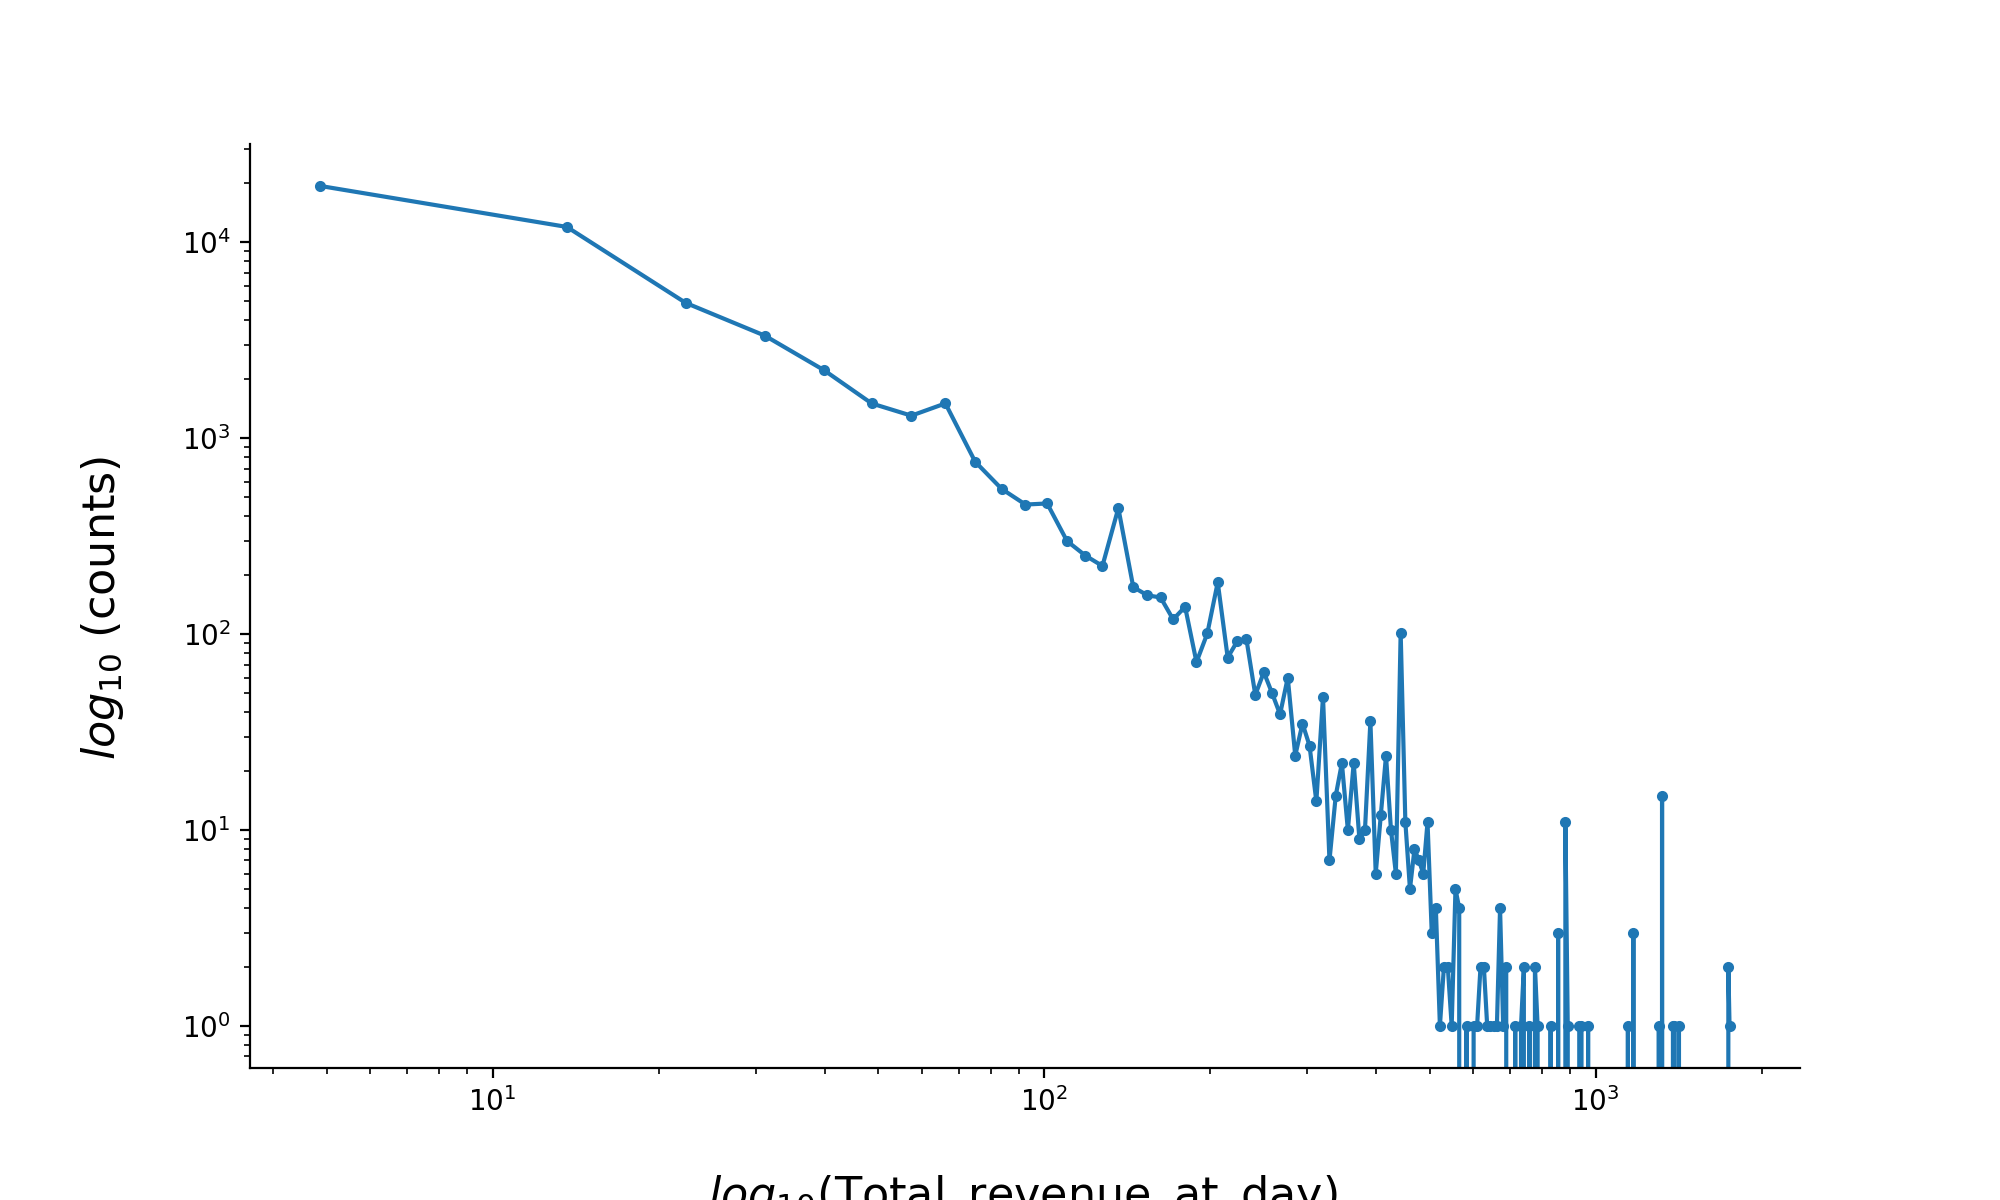



Looking at the revenue as a function of the user's index in the data frame:
(which is a proxy to the user's ID, which is a proxy to the user's seniority)


<IPython.core.display.Javascript object>


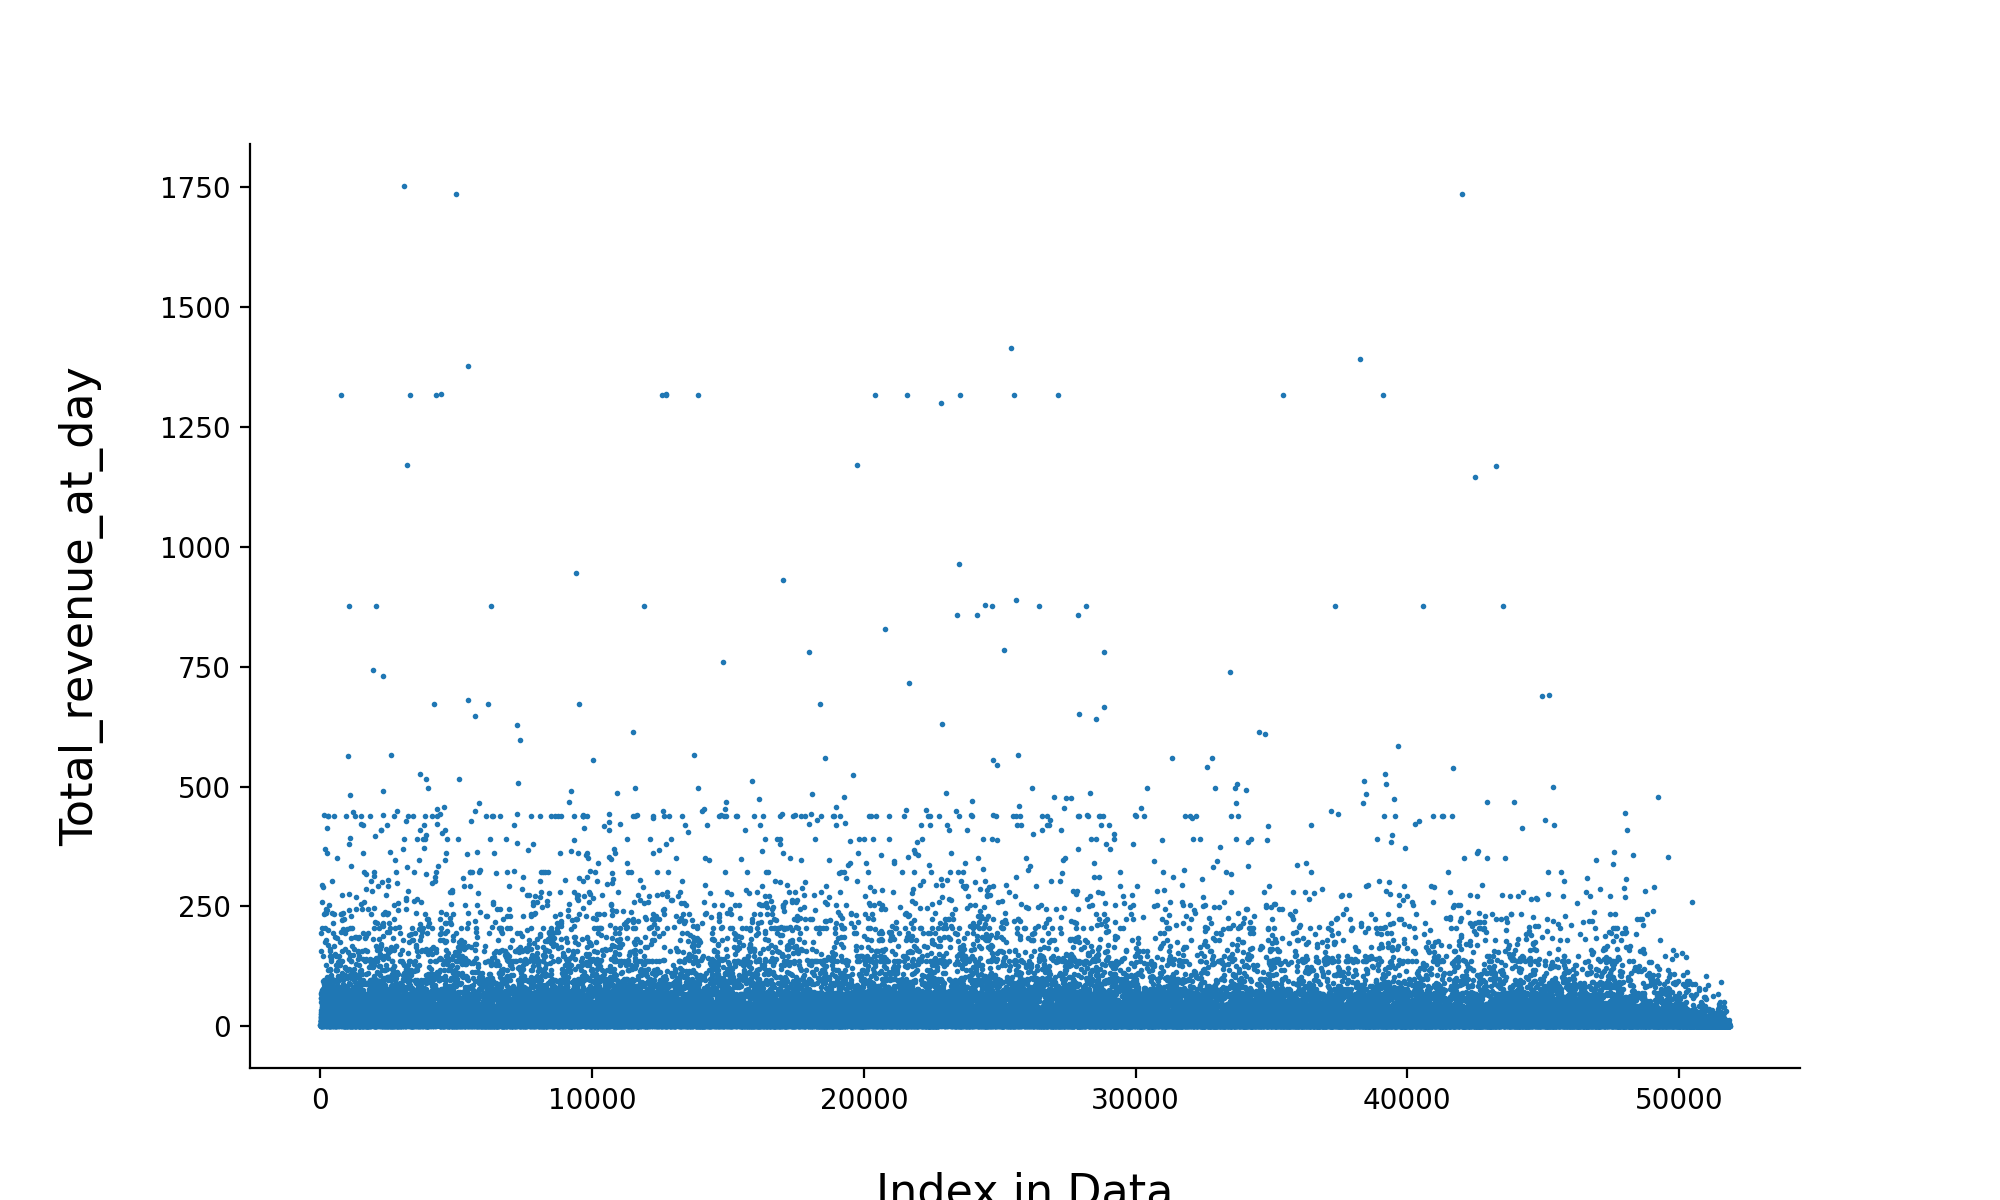

In [60]:
if parameters["data"]["target_data"]["init_data_analysis"]:
    if parameters["data"]["target_data"]["target_feature"] == "revenue": 
        data_target = run_revenue_init_data_analysis(data_target, 
                                                     target_column,
                                                     parameters["data"]["target_data"]["plot_figures"],
                                                     parameters["print_to_screen"])

[back to top](#back_to_top)  
[back to setting the parameters](#parameters) <a id='choose_features'></a>

## Choose features for clustering

In [151]:
if parameters["choose_features_for_clustering"]["randomly_choose"]:
    features_for_clustering = randomly_choose_features_for_clustering(numerical_features,
                                                                      parameters["choose_features_for_clustering"]["num_of_tupples"],
                                                                      parameters["choose_features_for_clustering"]["num_of_features"])    

else:
    features_for_clustering = parameters["choose_features_for_clustering"]["hand_picked_features_for_clustering"]
    checking_validity_of_hand_picked_features(features_for_clustering, numerical_features)



All features' sets hand picked for the clustering include only numerical features.
Can move on.




In [152]:
for features_tupple in features_for_clustering:
    print(features_tupple)

['level', 'Lifetime_Revenue_Net', 'credits_balance_EOD']


[back to top](#back_to_top)  
[back to setting the parameters](#parameters) <a id='kmeans'></a>

## K-Means and Homogeneity calculations

<IPython.core.display.Javascript object>


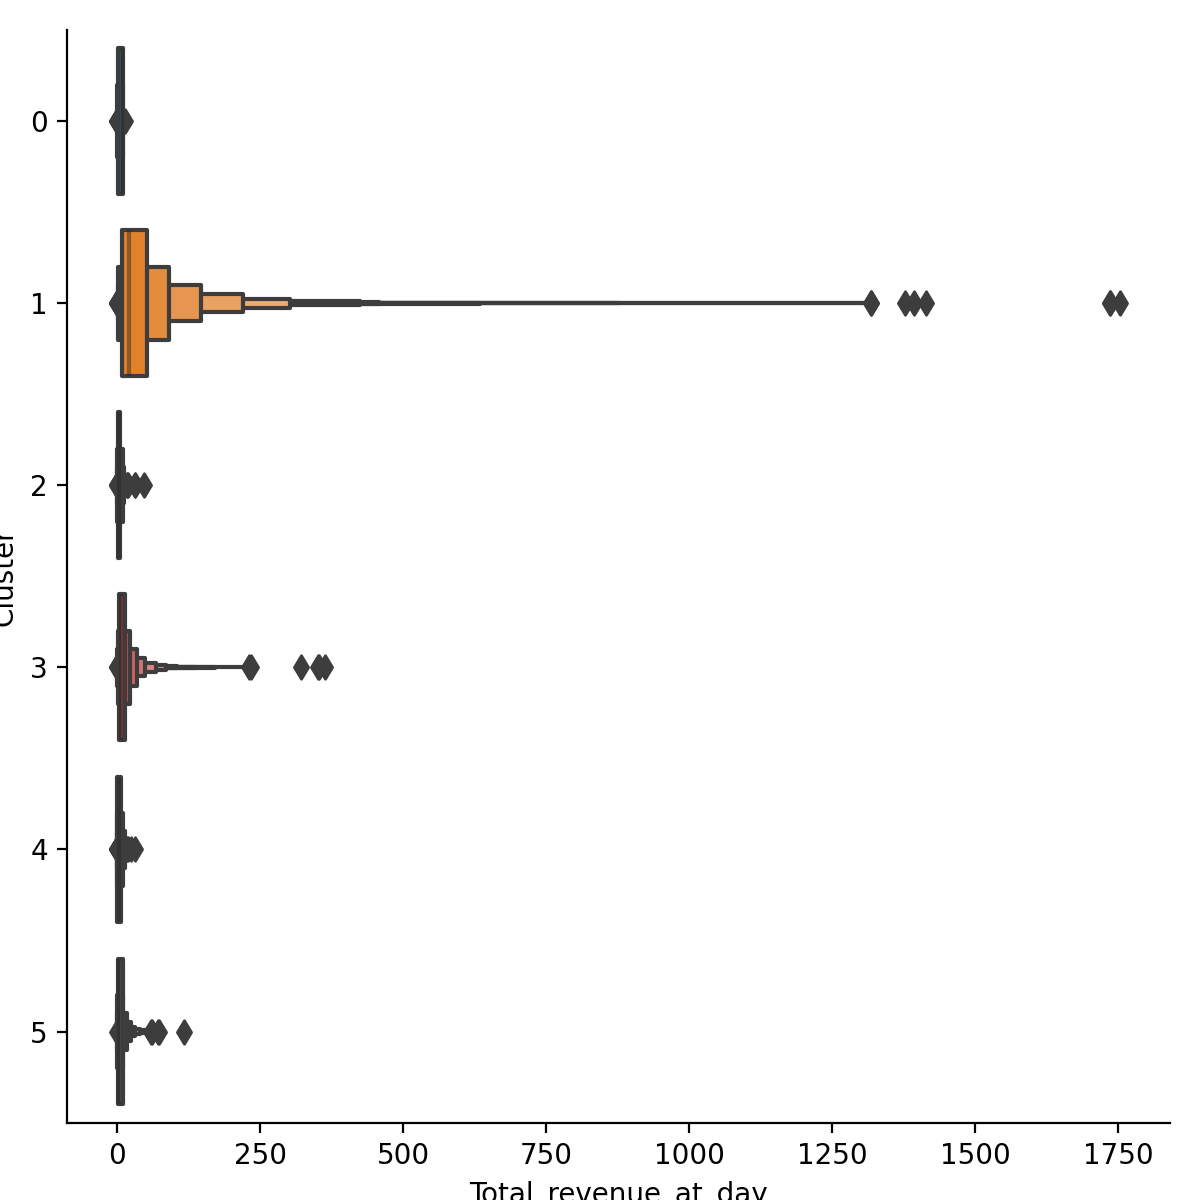



Percentile:
The average homogeneity over the bootstrap samples: 0.00313
The 0.025 MinMax is at: -0.19857
The 0.975 MinMax is at: 0.13045

The average weighted homogeneity over the bootstrap samples: 0.00267
The 0.025 MinMax is at: -0.00100
The 0.975 MinMax is at: 0.00704

\MinMax:
The average homogeneity over the bootstrap samples: 0.44338
The 0.025 MinMax is at: 0.32098
The 0.975 MinMax is at: 0.54053

The average weighted homogeneity over the bootstrap samples: 0.05061
The 0.025 MinMax is at: 0.01307
The 0.975 MinMax is at: 0.14198

\Distances:
The average homogeneity over the bootstrap samples: 0.00509
The 0.025 MinMax is at: -0.85227
The 0.975 MinMax is at: 0.32278

The average weighted homogeneity over the bootstrap samples: 0.00011
The 0.025 MinMax is at: 0.00002
The 0.975 MinMax is at: 0.00033


In [153]:
for ind, features_tupple in enumerate(features_for_clustering):
    results_summary["results"].update({"run_{}".format(ind): {}})
    results_summary["results"]["run_{}".format(ind)].update({"features_for_clustering": features_tupple})
    
    if parameters["print_to_screen"]:
        print("\n\n")
        print("---------------------------------------------------------------------\n")
        print("This is the {} random tupple running.\n".format(ind + 1))
    
    # Kmeans part:
    features_tupple.insert(0, 'dim_user_gid')
    X = create_df_for_kmeans(data_for_clustering, 
                             features_tupple,
                             parameters["kmeans"],
                             parameters["print_to_screen"])

    if parameters["kmeans"]["optimal_k"]["to_find_optimal_k"]:
        optimal_k = find_optimal_k(X, 
                                   parameters["kmeans"],
                                   parameters["print_to_screen"])
        
    if parameters["kmeans"]["choice_of_num_of_clusters"] == "sse":
        num_of_clusters = optimal_k["sse"]
    elif parameters["kmeans"]["choice_of_num_of_clusters"] == "silhouette":
        num_of_clusters = optimal_k["silhouette"]
    elif parameters["kmeans"]["choice_of_num_of_clusters"] == "manual":
        num_of_clusters = parameters["kmeans"]["hand_picked_num_of_clusters"]
    
    if parameters["print_to_screen"]:
        print("\nThe number of clusters is: {}".format(num_of_clusters))
        
    X = run_kmeans(X, 
                   num_of_clusters, 
                   parameters["kmeans"],
                   parameters["print_to_screen"])
    
    # Homogeneity part:
    X_merged_with_target = find_users_in_both_features_data_and_target(X, 
                                                                       data_target,
                                                                       parameters["print_to_screen"])
    
    if parameters["homogeneity"]["show_target_distribution_by_cluster"]:
        plot_dist_of_target_at_clusters(X_merged_with_target,
                                        target_column)
        
    if parameters["homogeneity"]["calc_homogeneity"]:
        homogeneity_results = calc_homogeneity(X_merged_with_target,
                                               num_of_clusters,
                                               target_column,
                                               parameters["homogeneity"],
                                               parameters["print_to_screen"])
    

[back to top](#back_to_top)  
[back to setting the parameters](#parameters) <a id='saving_results'></a>

## Saving the results

In [ ]:
results_summary.update({"parameters": parameters})